The following tutorial has been taken from one of the following websites which we encourage you to check out on your own. Some commands have been adapted to some of the datasets you’ve processed in this course.

- FAQs https://satijalab.org/seurat/faq
- Guided Clustering Tutorial https://satijalab.org/seurat/pbmc3k_tutorial.html
- Data Visualization Methodshttps://satijalab.org/seurat/visualization_vignette.html
- Cell Cycle Scoring https://satijalab.org/seurat/cell_cycle_vignette.html
- Integrating datasets https://satijalab.org/seurat/immune_alignment.html


In [1]:
library(Seurat)

# Load the Haber full dataset
haber.data <- Read10X(data.dir = "/home/ucsd-train27/scratch/projects/haber_batch1/cellranger_results/Atlas1_batch1/outs/filtered_gene_bc_matrices/mm10")

Loading required package: ggplot2
Loading required package: cowplot

Attaching package: 'cowplot'

The following object is masked from 'package:ggplot2':

    ggsave

Loading required package: Matrix


In [51]:
dim(haber.data)

[1] 27998  1595

In [3]:
# Initialize the Seurat object with the raw (non-normalized data).  Keep all
# genes expressed in >= 80 cells (~5% of the data). Keep all cells with at
# least 200 detected genes
haber <- CreateSeuratObject(raw.data = haber.data, min.cells = 80 , min.genes = 200)

## QC and selecting cells for further analysis##

While the CreateSeuratObject imposes a basic minimum gene-cutoff, you may want to filter out cells at this stage based on technical or biological parameters. Seurat allows you to easily explore QC metrics and filter cells based on any user-defined criteria. In the example below, we visualize gene and molecule counts, plot their relationship, and exclude cells with a clear outlier number of genes detected as potential multiplets. Of course this is not a guaranteed method to exclude cell doublets, but we include this as an example of filtering user-defined outlier cells. We also filter cells based on the percentage of mitochondrial genes present.

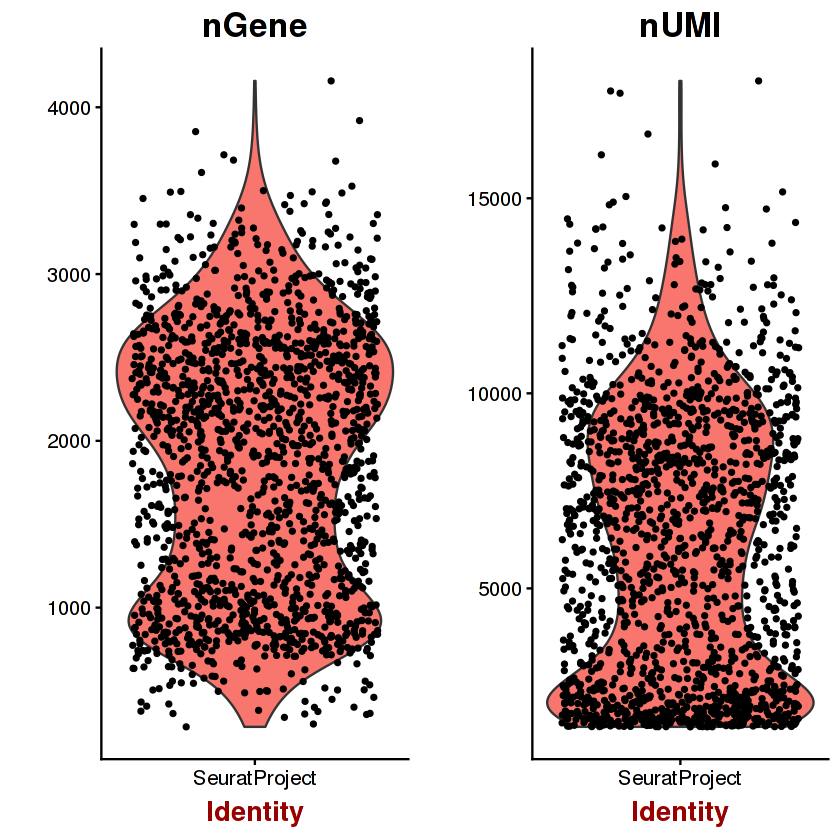

In [4]:
# The number of genes and UMIs (nGene and nUMI) are automatically calculated
# for every object by Seurat.  
VlnPlot(object = haber, features.plot = c("nGene", "nUMI"), nCol = 2)

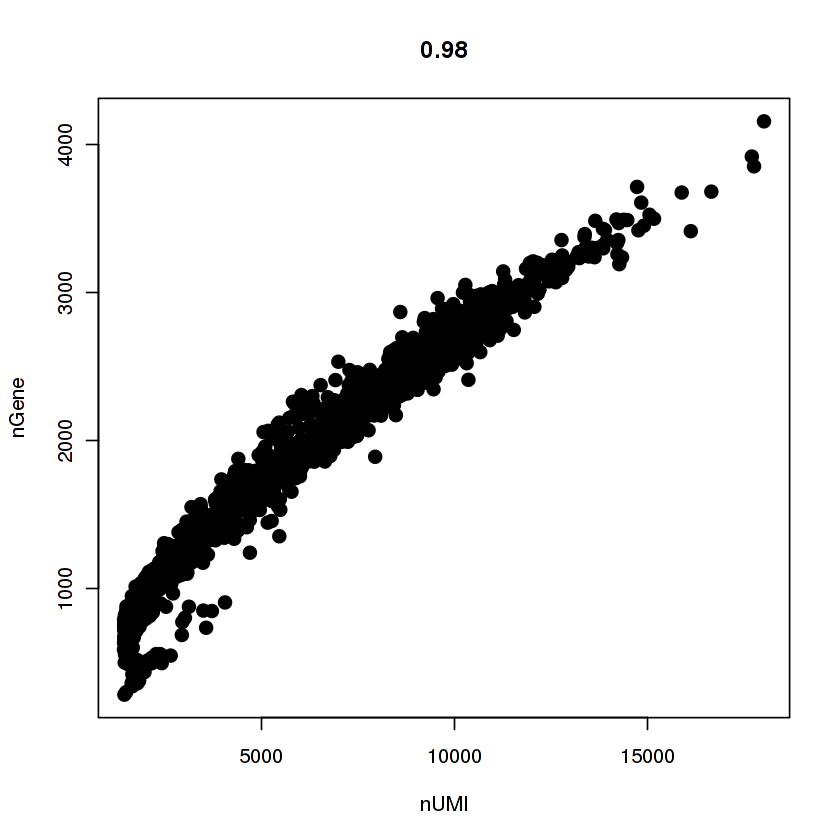

In [6]:
# GenePlot is typically used to visualize gene-gene relationships, but can
# be used for anything calculated by the object, i.e. columns in
# object@meta.data, PC scores etc.  We can filter low UMI
GenePlot(object = haber, gene1 = "nUMI", gene2 = "nGene")

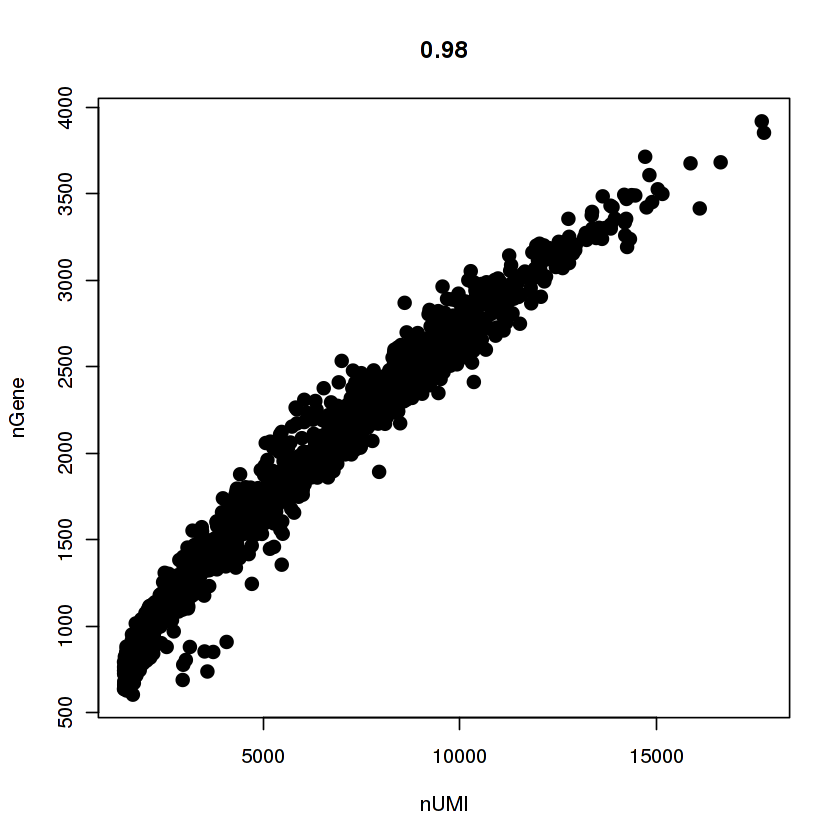

In [9]:
# We filter out cells that have unique gene counts over 2,500 or less than
# 200 Note that low.thresholds and high.thresholds are used to define a
# 'gate'.  -Inf and Inf should be used if you don't want a lower or upper
# threshold.
haber <- FilterCells(object = haber, subset.names = c("nGene"), 
    low.thresholds = c(600), high.thresholds = c(4000))
GenePlot(object = haber, gene1 = "nUMI", gene2 = "nGene")

## Normalizing the data ##
After removing unwanted cells from the dataset, the next step is to normalize the data. By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the gene expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result.

In [10]:
haber <- NormalizeData(object = haber, normalization.method = "LogNormalize", 
    scale.factor = 10000)

## Detection of variable genes across the single cells##
Seurat calculates highly variable genes and focuses on these for downstream analysis. FindVariableGenes calculates the average expression and dispersion for each gene, places these genes into bins, and then calculates a z-score for dispersion within each bin. This helps control for the relationship between variability and average expression. This function is unchanged from (Macosko et al.), but new methods for variable gene expression identification are coming soon. We suggest that users set these parameters to mark visual outliers on the dispersion plot, but the exact parameter settings may vary based on the data type, heterogeneity in the sample, and normalization strategy. The standard parameters here identify ~700 variable genes, and represent typical parameter settings for UMI data that is normalized to a total of 1e4 molecules.

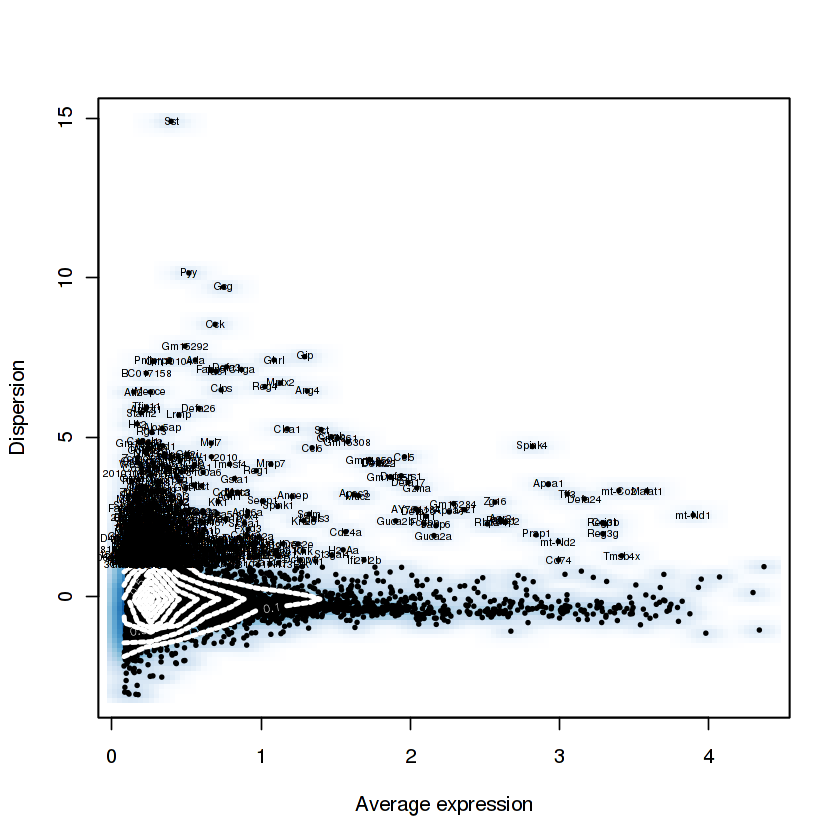

In [11]:
haber <- FindVariableGenes(object = haber)

In [12]:
length(x = haber@var.genes)

[1] 774

## Scaling the data and removing unwanted sources of variation ##
Your single cell dataset likely contains ‘uninteresting’ sources of variation. This could include not only technical noise, but batch effects, or even biological sources of variation (cell cycle stage). As suggested in Buettner et al, NBT, 2015, regressing these signals out of the analysis can improve downstream dimensionality reduction and clustering. To mitigate the effect of these signals, Seurat constructs linear models to predict gene expression based on user-defined variables. The scaled z-scored residuals of these models are stored in the scale.data slot, and are used for dimensionality reduction and clustering.

We can regress out cell-cell variation in gene expression driven by batch (if applicable), cell alignment rate (as provided by Drop-seq tools for Drop-seq data), the number of detected molecules, and mitochondrial gene expression. For cycling cells, we can also learn a ‘cell-cycle’ score (see example here) and regress this out as well. In this simple example here for post-mitotic blood cells, we regress on the number of detected molecules per cell as well as the percentage mitochondrial gene content.

In [13]:
haber <- ScaleData(object = haber, vars.to.regress = c("nUMI"))

[1] "Regressing out nUMI"
  |======================================================================| 100%
[1] "Scaling data matrix"
  |======================================================================| 100%


## Perform linear dimensional reduction ##
Next we perform PCA on the scaled data. By default, the genes in object@var.genes are used as input, but can be defined using pc.genes. We have typically found that running dimensionality reduction on highly variable genes can improve performance. However, with UMI data - particularly after regressing out technical variables, we often see that PCA returns similar (albeit slower) results when run on much larger subsets of genes, including the whole transcriptome.

In [14]:
haber <- RunPCA(object = haber, pc.genes = haber@var.genes, do.print = TRUE, pcs.print = 1:5, 
    genes.print = 5)

[1] "PC1"
[1] "Tmsb4x"   "Cd24a"    "Dctpp1"   "Sox4"     "Ceacam10"
[1] ""
[1] "Apoc3"  "Rbp2"   "Anpep"  "Apoa1"  "Spink1"
[1] ""
[1] ""
[1] "PC2"
[1] "Prap1"         "Cd74"          "Dctpp1"        "2810417H13Rik"
[5] "mt-Nd1"       
[1] ""
[1] "Selm"   "Ccl6"   "Muc2"   "Spink4" "Tff3"  
[1] ""
[1] ""
[1] "PC3"
[1] "Gm7861"   "Defa-rs1" "Defa26"   "Gm10104"  "Defa17"  
[1] ""
[1] "Tuba1a"  "Tm4sf4"  "Aplp1"   "Kctd12"  "Fam183b"
[1] ""
[1] ""
[1] "PC4"
[1] "Tpsg1"  "Clca1"  "S100a6" "Fcgbp"  "Lrrc26"
[1] ""
[1] "Gm7861"   "Defa-rs1" "Gm14851"  "Gm14850"  "Gm10104" 
[1] ""
[1] ""
[1] "PC5"
[1] "Lrmp"    "Alox5ap" "Rgs13"   "Ltc4s"   "Kctd12" 
[1] ""
[1] "Aplp1"   "Chgb"    "Fam183b" "Chga"    "Gch1"   
[1] ""
[1] ""


Seurat provides several useful ways of visualizing both cells and genes that define the PCA, including PrintPCA, VizPCA,  PCAPlot, and PCHeatmap

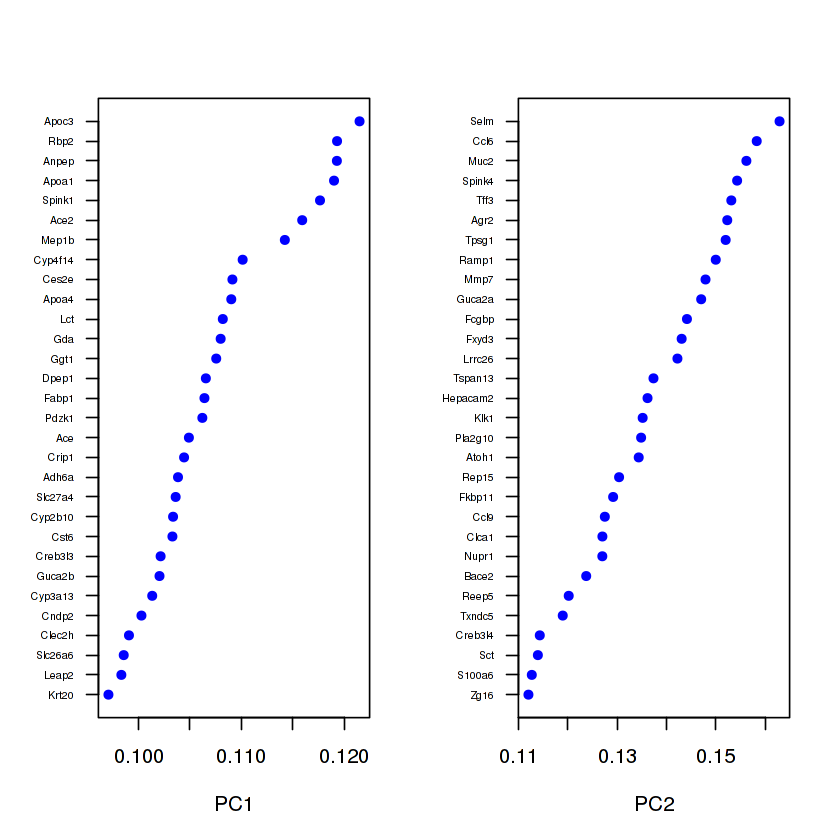

In [15]:
VizPCA(object = haber, pcs.use = 1:2)

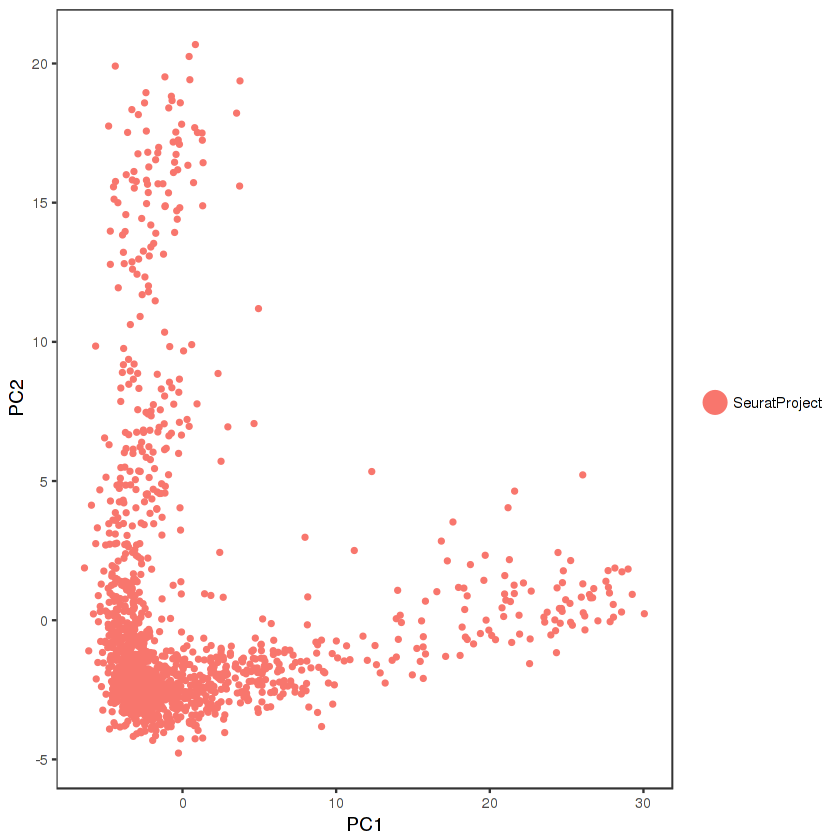

In [16]:
PCAPlot(object = haber, dim.1 = 1, dim.2 = 2)

In particular PCHeatmap allows for easy exploration of the primary sources of heterogeneity in a dataset, and can be useful when trying to decide which PCs to include for further downstream analyses. Both cells and genes are ordered according to their PCA scores. Setting cells.use to a number plots the ‘extreme’ cells on both ends of the spectrum, which dramatically speeds plotting for large datasets. Though clearly a supervised analysis, we find this to be a valuable tool for exploring correlated gene sets.

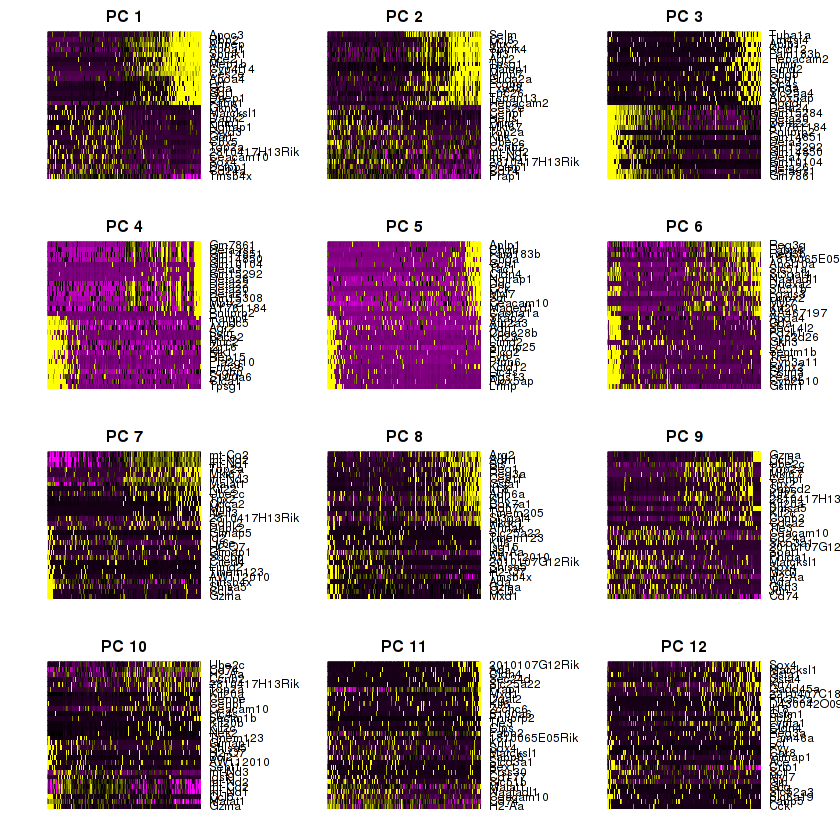

In [18]:
PCHeatmap(object = haber, pc.use = 1:12, cells.use = 500, do.balanced = TRUE, 
    label.columns = FALSE, use.full = FALSE)

## Determine statistically significant principal components ##
To overcome the extensive technical noise in any single gene for scRNA-seq data, Seurat clusters cells based on their PCA scores, with each PC essentially representing a ‘metagene’ that combines information across a correlated gene set. Determining how many PCs to include downstream is therefore an important step.

In Macosko et al, we implemented a resampling test inspired by the jackStraw procedure. We randomly permute a subset of the data (1% by default) and rerun PCA, constructing a ‘null distribution’ of gene scores, and repeat this procedure. We identify ‘significant’ PCs as those who have a strong enrichment of low p-value genes.

In [21]:
# NOTE: This process can take a long time for big datasets, comment out for
# expediency.  More approximate techniques such as those implemented in
# PCElbowPlot() can be used to reduce computation time
haber <- JackStraw(object = haber, num.replicate = 100)

The JackStrawPlot function provides a visualization tool for comparing the distribution of p-values for each PC with a uniform distribution (dashed line). ‘Significant’ PCs will show a strong enrichment of genes with low p-values (solid curve above the dashed line). In this case it appears that PCs 1-10 are significant.

Warning message:
"Removed 10329 rows containing missing values (geom_point)."

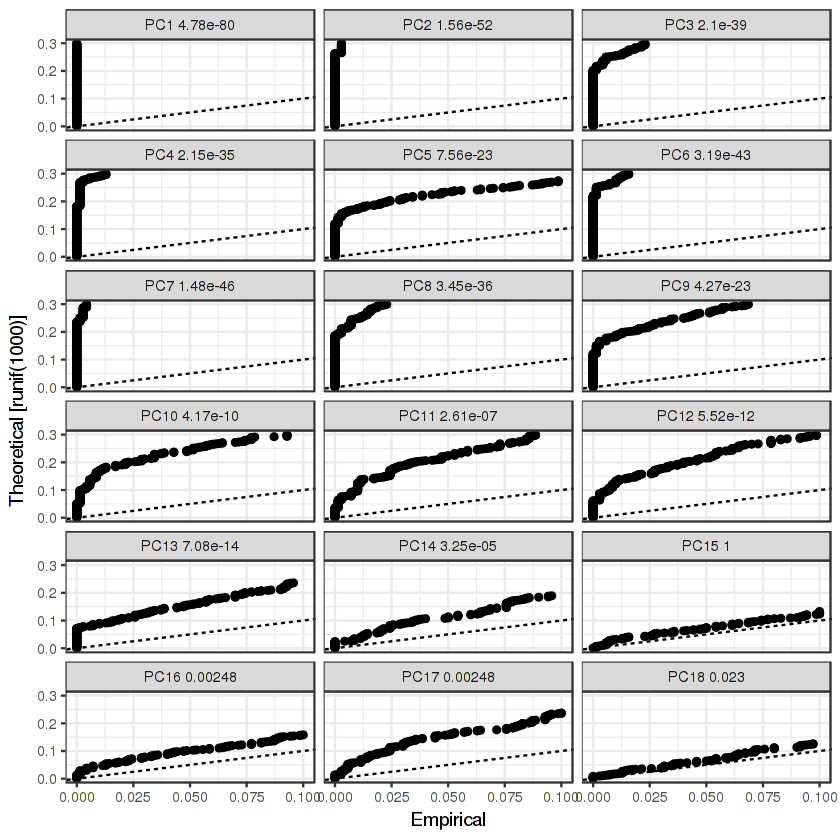

In [24]:
JackStrawPlot(object = haber, PCs = 1:18)

A more ad hoc method for determining which PCs to use is to look at a plot of the standard deviations of the principle components and draw your cutoff where there is a clear elbow in the graph. This can be done with PCElbowPlot. In this example, it looks like the elbow would fall around PC 9.

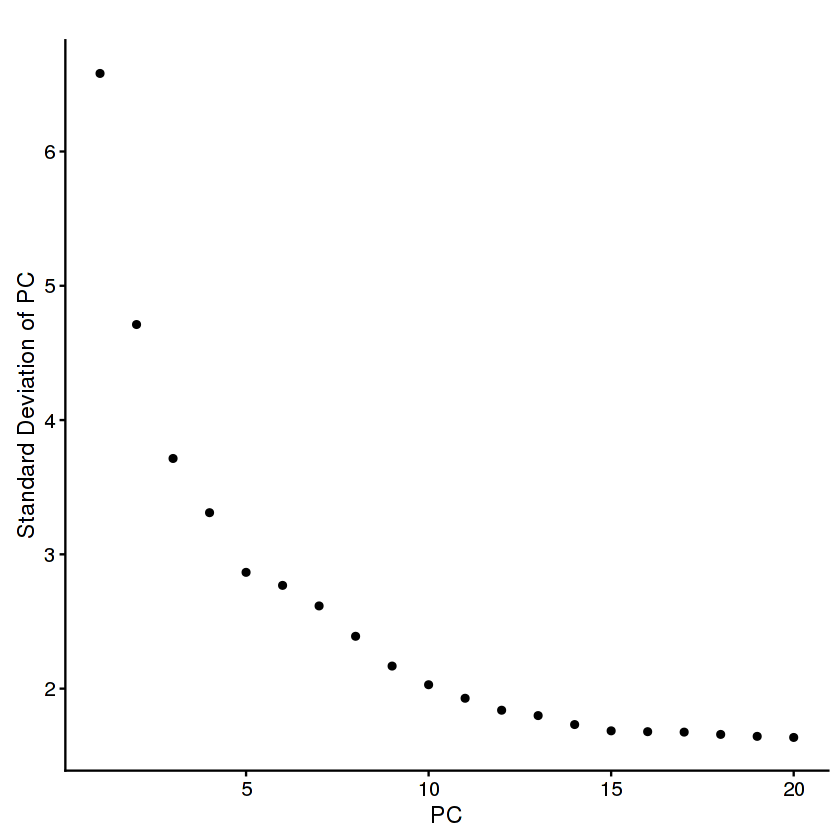

In [23]:
PCElbowPlot(object = haber)

PC selection – identifying the true dimensionality of a dataset – is an important step for Seurat, but can be challenging/uncertain for the user. We therefore suggest these three approaches to consider. The first is more supervised, exploring PCs to determine relevant sources of heterogeneity, and could be used in conjunction with GSEA for example. The second implements a statistical test based on a random null model, but is time-consuming for large datasets, and may not return a clear PC cutoff. The third is a heuristic that is commonly used, and can be calculated instantly. In this example, all three approaches yielded similar results, but we might have been justified in choosing anything between PC 7-10 as a cutoff. We followed the jackStraw here, admittedly buoyed by seeing the PCHeatmap returning interpretable signals (including canonical dendritic cell markers) throughout these PCs. Though the results are only subtly affected by small shifts in this cutoff (you can test below), we strongly suggest always explore the PCs they choose to include downstream.

## Cluster the cells ##
Seurat now includes an graph-based clustering approach compared to (Macosko et al.). Importantly, the distance metric which drives the clustering analysis (based on previously identified PCs) remains the same. However, our approach to partioning the cellular distance matrix into clusters has dramatically improved. Our approach was heavily inspired by recent manuscripts which applied graph-based clustering approaches to scRNA-seq data [SNN-Cliq, Xu and Su, Bioinformatics, 2015] and CyTOF data [PhenoGraph, Levine et al., Cell, 2015]. Briefly, these methods embed cells in a graph structure - for example a K-nearest neighbor (KNN) graph, with edges drawn between cells with similar gene expression patterns, and then attempt to partition this graph into highly interconnected ‘quasi-cliques’ or ‘communities’. As in PhenoGraph, we first construct a KNN graph based on the euclidean distance in PCA space, and refine the edge weights between any two cells based on the shared overlap in their local neighborhoods (Jaccard similarity). To cluster the cells, we apply modularity optimization techniques such as the Louvain algorithm (default) or SLM [SLM, Blondel et al., Journal of Statistical Mechanics], to iteratively group cells together, with the goal of optimizing the standard modularity function.

The FindClusters function implements the procedure, and contains a resolution parameter that sets the ‘granularity’ of the downstream clustering, with increased values leading to a greater number of clusters. We find that setting this parameter between 0.6-1.2 typically returns good results for single cell datasets of around 3K cells. Optimal resolution often increases for larger datasets. The clusters are saved in the object@ident slot.

In [25]:
# save.SNN = T saves the SNN so that the clustering algorithm can be rerun
# using the same graph but with a different resolution value (see docs for
# full details)
haber <- FindClusters(object = haber, reduction.type = "pca", dims.use = 1:15, 
    resolution = 0.6, print.output = 0, save.SNN = TRUE)

A useful feature in Seurat v2.0 is the ability to recall the parameters that were used in the latest function calls for commonly used functions. For FindClusters, we provide the function PrintFindClustersParams to print a nicely formatted formatted summary of the parameters that were chosen.

In [26]:
PrintFindClustersParams(object = haber)

Parameters used in latest FindClusters calculation run on: 2018-07-12 08:17:22
Resolution: 0.6
-----------------------------------------------------------------------------
Modularity Function    Algorithm         n.start         n.iter
     1                   1                 100             10
-----------------------------------------------------------------------------
Reduction used          k.param          k.scale          prune.SNN
     pca                 30                25              0.0667
-----------------------------------------------------------------------------
Dims used in calculation
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15



## Run Non-linear dimensional reduction (tSNE) ##
Seurat continues to use tSNE as a powerful tool to visualize and explore these datasets. While we no longer advise clustering directly on tSNE components, cells within the graph-based clusters determined above should co-localize on the tSNE plot. This is because the tSNE aims to place cells with similar local neighborhoods in high-dimensional space together in low-dimensional space. As input to the tSNE, we suggest using the same PCs as input to the clustering analysis, although computing the tSNE based on scaled gene expression is also supported using the genes.use argument.

In [27]:
haber <- RunTSNE(object = haber, dims.use = 1:15, do.fast = TRUE)

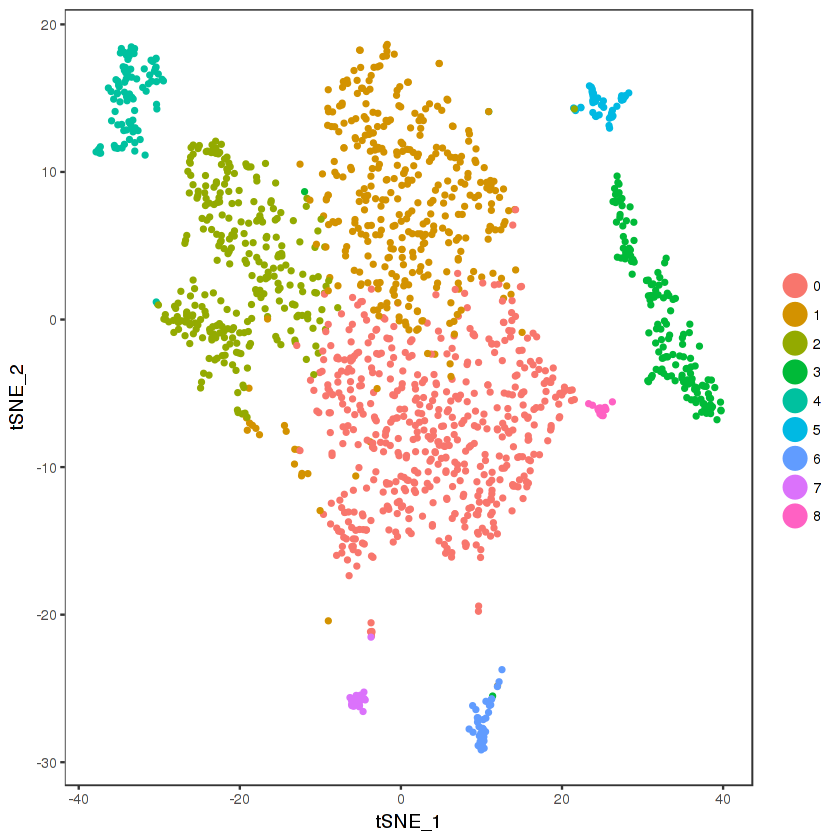

In [28]:
# note that you can set do.label=T to help label individual clusters
TSNEPlot(object = haber)

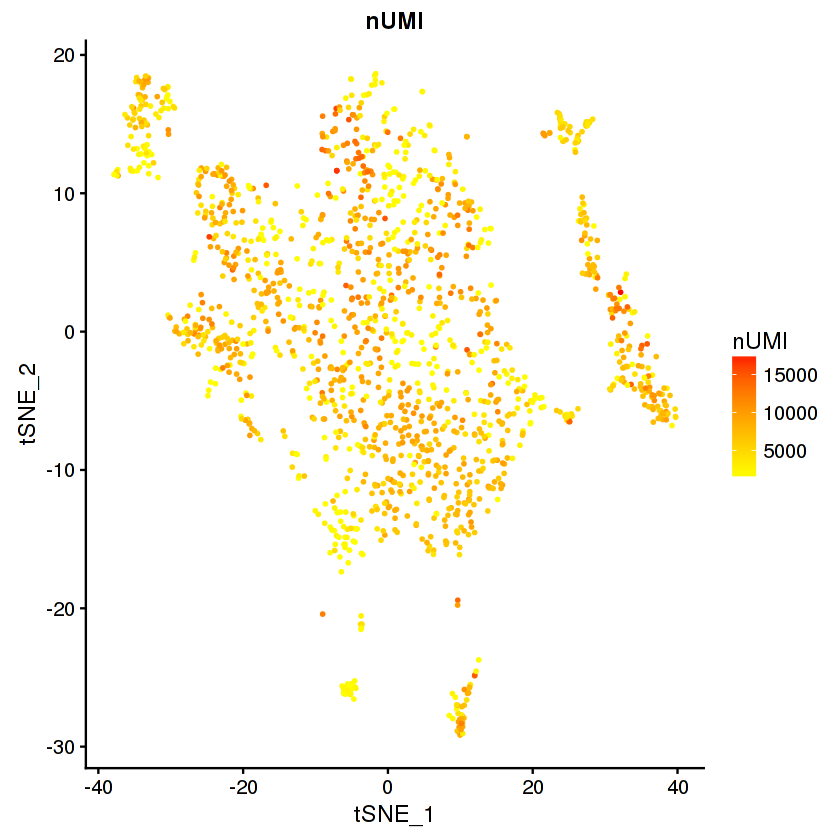

In [49]:
# Visualization by UMI counts
FeaturePlot(haber, features.plot=c('nUMI'), pt.size=1, no.legend = FALSE)

## Finding differentially expressed genes (cluster biomarkers) ##
Seurat can help you find markers that define clusters via differential expression. By default, it identifes positive and negative markers of a single cluster (specified in ident.1), compared to all other cells. FindAllMarkers automates this process for all clusters, but you can also test groups of clusters vs. each other, or against all cells.

The min.pct argument requires a gene to be detected at a minimum percentage in either of the two groups of cells, and the thresh.test argument requires a gene to be differentially expressed (on average) by some amount between the two groups. You can set both of these to 0, but with a dramatic increase in time - since this will test a large number of genes that are unlikely to be highly discriminatory. As another option to speed up these computations, max.cells.per.ident can be set. This will downsample each identity class to have no more cells than whatever this is set to. While there is generally going to be a loss in power, the speed increases can be significiant and the most highly differentially expressed genes will likely still rise to the top.

In [32]:
# find markers for every cluster compared to all remaining cells, report
# only the positive ones
haber.markers <- FindAllMarkers(object = haber, only.pos = TRUE)

In [50]:
library(dplyr)
top5 <- haber.markers %>% group_by(cluster) %>% top_n(5, avg_logFC)
top5

p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
1.166462e-99,1.2850137,0.858,0.481,8.767131e-96,0,Ifitm3
3.025277e-80,0.7634718,0.923,0.765,2.273798e-76,0,Npm1
8.888178e-75,0.7470773,0.910,0.675,6.680354e-71,0,Ifitm2
9.886986e-58,0.7924924,0.677,0.289,7.431059e-54,0,Slc12a2
2.523489e-55,0.7670195,0.675,0.300,1.896654e-51,0,Amica1
1.042883e-79,1.2772578,0.647,0.179,7.838309e-76,1,Top2a
1.614954e-61,0.9656998,0.578,0.167,1.213800e-57,1,Mki67
3.782648e-54,1.1366010,0.626,0.275,2.843038e-50,1,Ube2c
6.593950e-54,1.0048087,0.653,0.270,4.956013e-50,1,2810417H13Rik
5.657275e-44,0.8473378,0.878,0.612,4.252008e-40,1,Dmbt1


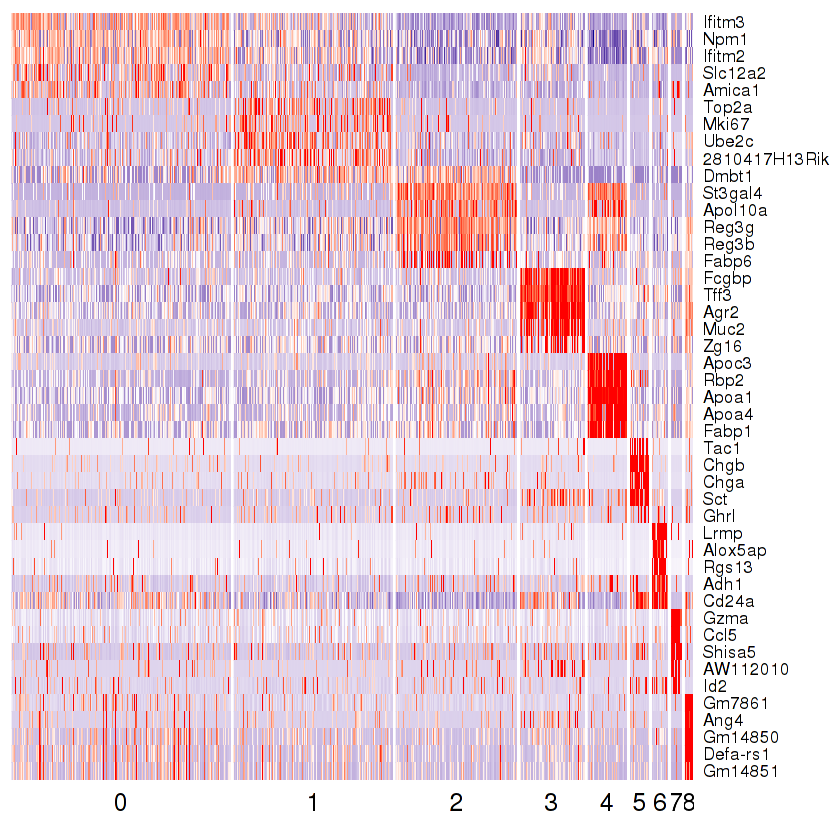

In [46]:
DoHeatmap(object = haber, genes.use = top5$gene, slim.col.label = TRUE, remove.key = TRUE, col.low = "blue4",
  col.mid = "white", col.high = "red")

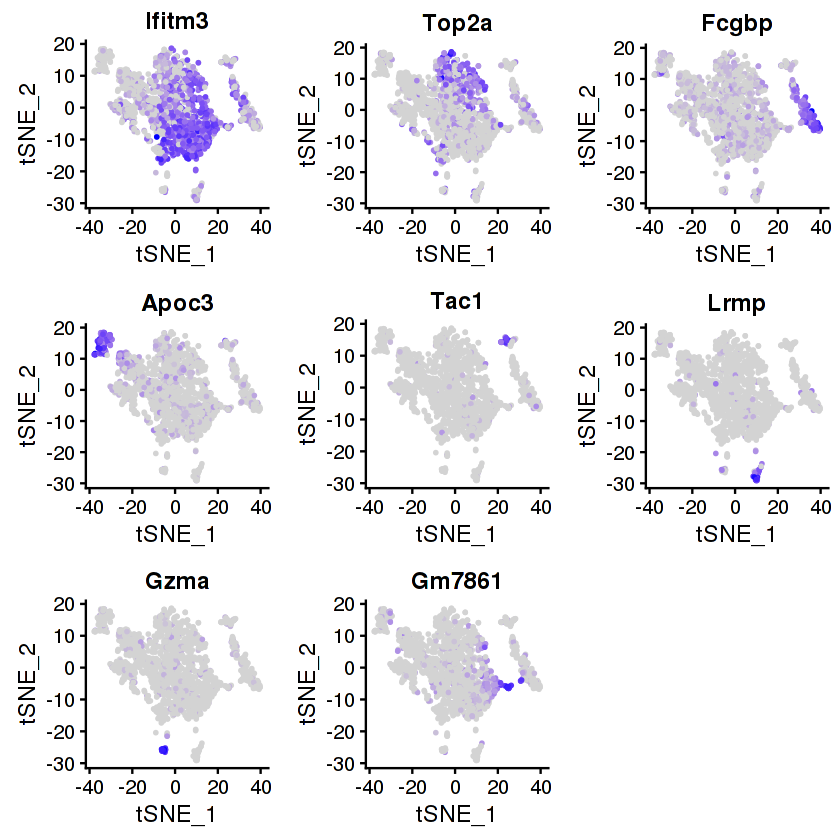

In [37]:
FeaturePlot(object = haber, features.plot = c("Ifitm3","Top2a","Fcgbp","Apoc3","Tac1","Lrmp","Gzma","Gm7861"), 
            cols.use = c("lightgrey", "blue"))

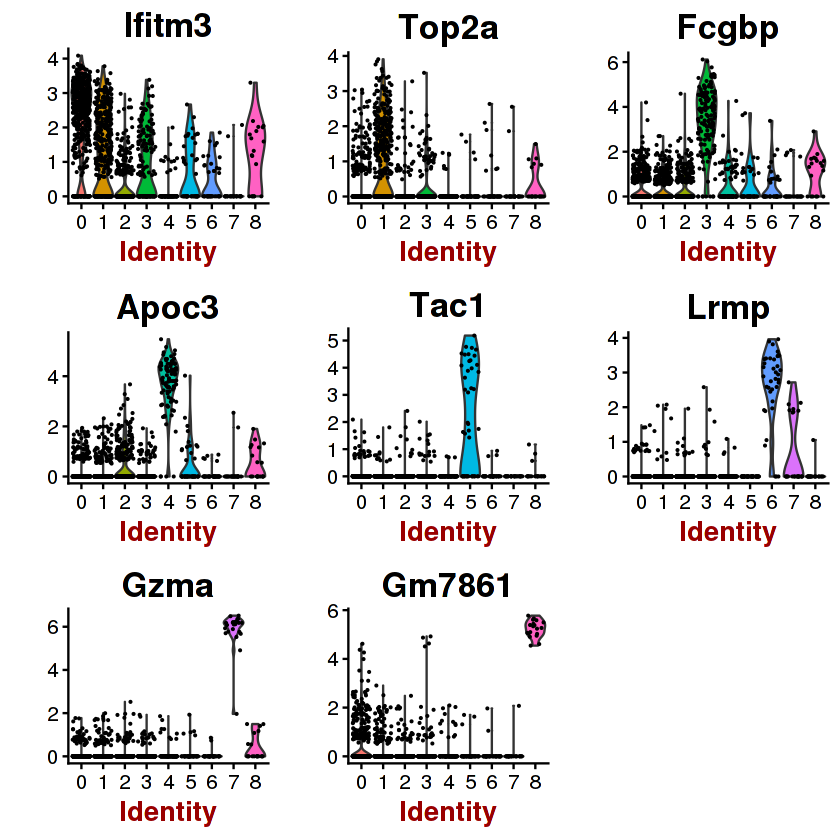

In [39]:
VlnPlot(object = haber, features.plot = c("Ifitm3","Top2a","Fcgbp","Apoc3","Tac1","Lrmp","Gzma","Gm7861"),point.size.use=0.1)

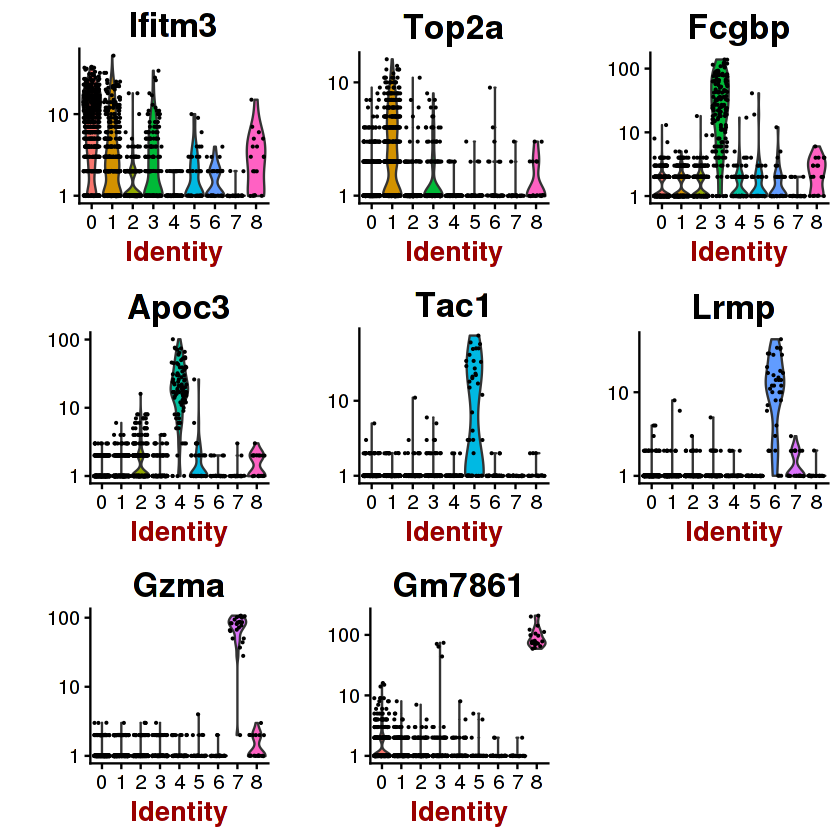

In [40]:
VlnPlot(object = haber, features.plot = c("Ifitm3","Top2a","Fcgbp","Apoc3","Tac1","Lrmp","Gzma","Gm7861")
        ,point.size.use=0.1, use.raw = T, y.log=T)

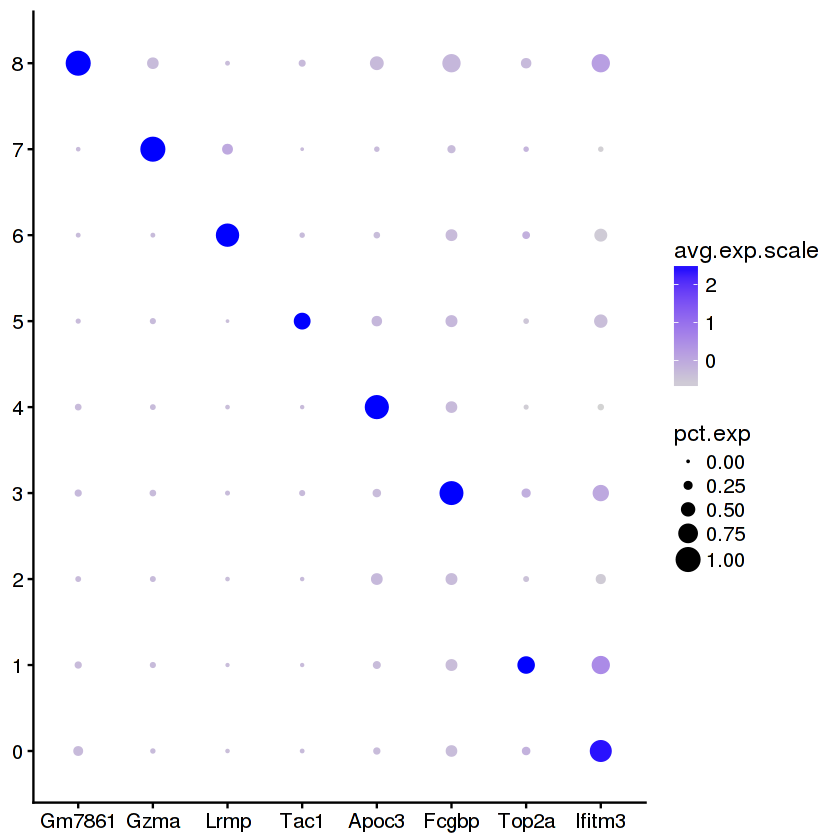

In [48]:
# Dot plots - the size of the dot corresponds to the percentage of cells
# expressing the gene in each cluster. The color represents the average
# expression level
DotPlot(object = haber, genes.plot = c("Ifitm3","Top2a","Fcgbp","Apoc3","Tac1","Lrmp","Gzma","Gm7861"),
        plot.legend = TRUE)